# Introduction



In [216]:
# packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from math import sqrt, log
from sklearn.metrics import make_scorer



# Data Cleaning and Imputation

In [217]:
# load data & preview data
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

display(df_train.tail())
print(df_train.shape)
display(df_test.head())
print(df_test.shape)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


(1459, 80)


In [218]:
# examine dependent variable
display(df_train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

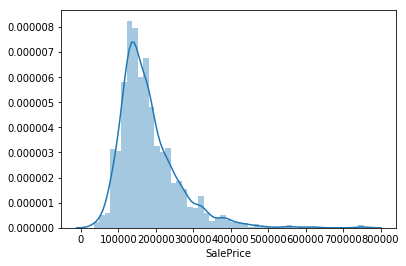

In [219]:
sns.distplot(df_train['SalePrice'])

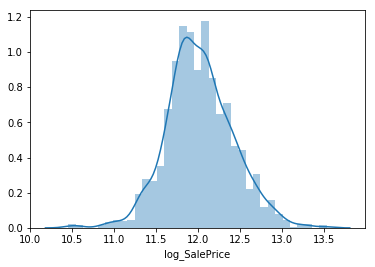

In [220]:
df_train['log_SalePrice'] = np.log1p(df_train['SalePrice'])

sns.distplot(df_train['log_SalePrice'])

In [221]:
# combine train and test sets
df_combined = pd.concat([df_train.drop('SalePrice', axis = 1), df_test], sort = True)

print(df_combined.shape)

# check for missing values.
total = df_combined.isnull().sum().sort_values(ascending=False)
percent = (df_combined.isnull().sum()/df_combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()
# we have 

(2919, 81)


,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
log_SalePrice,1459,0.499829


There are 35 fields with missing values, we try to fill them in here. Note it is important to merge training and test sets before checking for missing values. Using only the training set there is only 19 variables with missing values.

# Simple Data Imputation

In [222]:
df_combined = df_combined[df_train.drop('SalePrice', axis = 1).columns]
display(df_combined.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,log_SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [223]:
all_data = df_combined.loc[:, 'Id':'SaleCondition']
display(all_data.head())
print(all_data.shape)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


(2919, 80)


In [224]:
# fill numerical values with their mean
all_data = all_data.fillna(all_data.mean())
display(all_data.head(10))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.000000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.000000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.000000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.000000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,6,50,RL,85.000000,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,7,20,RL,75.000000,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,8,60,RL,69.305795,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,9,50,RM,51.000000,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,10,190,RL,50.000000,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


In [225]:
# create dummy variables for categoroical data
all_data = pd.get_dummies(all_data)
display(all_data.head(10))
print(all_data.shape)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.000000,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.000000,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.000000,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.000000,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.000000,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0
5,6,50,85.000000,14115,5,5,1993,1995,0.0,732.0,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.000000,10084,8,5,2004,2005,186.0,1369.0,...,0,0,0,1,0,0,0,0,1,0
7,8,60,69.305795,10382,7,6,1973,1973,240.0,859.0,...,0,0,0,1,0,0,0,0,1,0
8,9,50,51.000000,6120,7,5,1931,1950,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
9,10,190,50.000000,7420,5,6,1939,1950,0.0,851.0,...,0,0,0,1,0,0,0,0,1,0


(2919, 289)


In [226]:
# check for missing values.
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
SaleCondition_Partial,0,0.0
Exterior1st_Stone,0,0.0
Condition1_Norm,0,0.0
Condition1_PosA,0,0.0
Condition1_PosN,0,0.0


In [227]:
all_data.shape

(2919, 289)

# Output training and test sets

To be used for modelling

In [228]:
# merge sale price back into training set
train_data = all_data.iloc[0 : len(df_train)]
train_data = train_data.merge(df_train[['Id',  'SalePrice']], on = 'Id')

print(train_data.shape)

target = train_data['SalePrice']
X = train_data.drop('SalePrice', axis = 1)

test_data = all_data.iloc[len(df_train):, ]
print(test_data.shape)

display(target.head())

#train_data = train_data.set_index('Id')
#test_data = test_data.set_index('Id')

# train_data.to_csv('../cleaned_data/train_data_simple_clean.csv')
# test_data.to_csv('../cleaned_data/test_data_simple_clean.csv')

(1460, 290)
(1459, 289)


0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

# Preprocessing and Modelling

In [229]:
# Identify target variable and drop it from 
target = train_data['SalePrice']
X = train_data.drop(['SalePrice', 'Id'], axis = 1)

# Preview Data
display(train_data.tail())
display(test_data.head())

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0.0,...,0,0,1,0,0,0,0,1,0,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790.0,...,0,0,1,0,0,0,0,1,0,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275.0,...,0,0,1,0,0,0,0,1,0,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49.0,...,0,0,1,0,0,0,0,1,0,142125
1459,1460,20,75.0,9937,5,6,1965,1965,0.0,830.0,...,0,0,1,0,0,0,0,1,0,147500


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0


In [230]:
# function to ensure no negative values are predited
def pos_func(a):
    if (a > 0): return a
    else: return 0
pos_func = np.vectorize(pos_func)

# Scoring function.
# In order to test for kaggle score we must create a function to score predictions as they are scored in the competition rules
def rmse_log(values, predictions):
    delta_preds = pos_func(predictions)

    log_vals = np.log1p(values)
    log_preds = np.log1p(delta_preds)
    
    return sqrt(mean_squared_error(log_vals, log_preds))

In [231]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.3)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

display(X_train.head())

X_train : (1022, 288)
X_test : (438, 288)
y_train : (1022,)
y_test : (438,)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1188,60,68.000000,8935,7,5,2002,2002,95.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1233,20,69.305795,12160,5,5,1959,1959,180.0,1000.0,0.0,...,0,0,0,0,1,0,0,0,0,0
46,50,48.000000,12822,7,5,2003,2003,0.0,1351.0,0.0,...,0,0,0,1,1,0,0,0,0,0
1280,20,67.000000,9808,7,5,2002,2002,110.0,788.0,0.0,...,0,0,0,1,0,0,0,0,1,0
404,60,69.305795,10364,6,5,1995,1996,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0


## Linear Regression

The R-squared on the training set is 0.9351
The R-squared on the test set is 0.6832
--------------------------------------------------
The MSE on the training set is 0.10
The MSE on the test set is 0.19


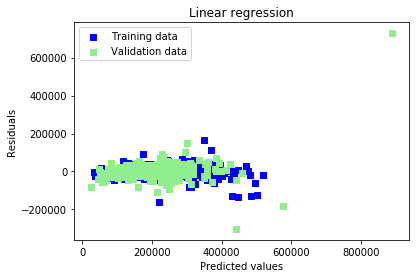

In [232]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# get preditictions for training and test set.
y_train_pred = pos_func(lr.predict(X_train))
y_test_pred = pos_func(lr.predict(X_test))


# R-squared
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# RMSE of log of Sale Price
train_rmse = rmse_log(y_train, y_train_pred)
test_rmse = rmse_log(y_test, y_test_pred)

# display model fit metrics.
print(f"The R-squared on the training set is {train_r2:,.4f}")
print(f"The R-squared on the test set is {test_r2:,.4f}")
print('-' * 50)
print(f"The MSE on the training set is {train_rmse:,.2f}")
print(f"The MSE on the test set is {test_rmse:,.2f}")


# residuals
train_resids = y_train_pred - y_train
test_resids = y_test_pred - y_test

# Plot residuals
plt.scatter(y_train_pred, train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()


In [233]:
# predictions for competitiion submission
model_predicts = pos_func(lr.predict(test_data.drop('Id', axis = 1)))

lin_reg_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':model_predicts})
lin_reg_submission = lin_reg_submission.set_index('Id')

# preview submission to ensure format is correct.
display(lin_reg_submission.head())


# lin_reg_submission.to_csv('../submissions/01_simple_models/linear_regression.csv')

,SalePrice
Id,
1461,122037.735505
1462,215509.095969
1463,189396.470419
1464,201799.478081
1465,213904.338909


## Ridge Regression

Best parameters: {'alpha': 25}
Best cross-validation score: 0.14876344605172495
Test set score: 0.15248176270776792


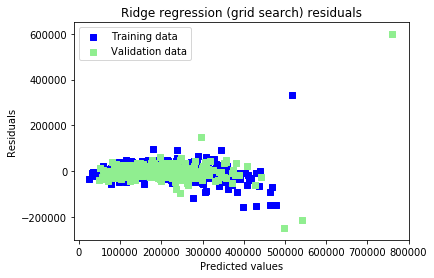

In [234]:
# now lets do a grid search to try improve our score
param_grid = {'alpha' : [0.001, 0.01, 0.1, 1, 10, 25,  50, 75, 100]}

# create scoring function to be used in grid search
my_scorer = make_scorer(rmse_log, greater_is_better = False)

# create grid search and fit
ridge_grid_search = GridSearchCV(Ridge(), param_grid, cv = 5, scoring = my_scorer)
ridge_grid_search.fit(X_train, y_train)

# display model fit parameters.
print('Best parameters: {}'.format(ridge_grid_search.best_params_))
print('Best cross-validation score: {}'.format(-ridge_grid_search.best_score_))
print('Test set score: {}'.format(-ridge_grid_search.score(X_test, y_test)))

# predictions for training and test set.
ridge_train_pred = pos_func(ridge_grid_search.predict(X_train))
ridge_test_pred = pos_func(ridge_grid_search.predict(X_test))


# residuals
ridge_train_resids = ridge_train_pred - y_train
ridge_test_resids = ridge_test_pred - y_test

# Plot residuals
plt.scatter(ridge_train_pred, ridge_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(ridge_test_pred, ridge_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Ridge regression (grid search) residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()


In [235]:
# predictions for comp entry.
ridge_grid_predicts = pos_func(ridge_grid_search.predict(test_data.drop('Id', axis = 1)))
ridge_grid_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':ridge_grid_predicts})
ridge_grid_submission = ridge_grid_submission.set_index('Id')

# preview submission
display(ridge_grid_submission.head())

# ridge_grid_submission.to_csv('../submissions/01_simple_models/ridge_grid_regression.csv')

,SalePrice
Id,
1461,115418.952712
1462,162237.844148
1463,180347.107442
1464,197898.951579
1465,196004.426819


## Lasso Regression

Best parameters: {'alpha': 175}
Best cross-validation score: 0.15345233703808947
Test set score: 0.1501140398847786


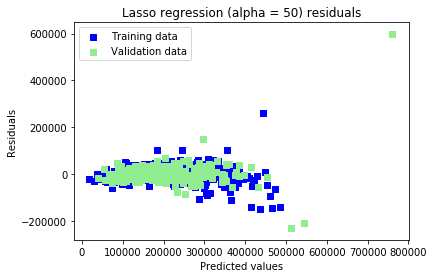

In [236]:
# now let's add a grid search to try improve our score.
# parameter grid to search over.
param_grid = {'alpha' : [50, 75, 100, 125, 150, 175, 400, 1000]}

# grid search and fit lasso
lasso_grid_search = GridSearchCV(Lasso(max_iter=100000), param_grid, cv = 5, scoring = my_scorer)
lasso_grid_search.fit(X_train, y_train)


print('Best parameters: {}'.format(lasso_grid_search.best_params_))
print('Best cross-validation score: {}'.format(-lasso_grid_search.best_score_))
print('Test set score: {}'.format(-lasso_grid_search.score(X_test, y_test)))


# predictions for training and test set.
lasso_train_pred = pos_func(lasso_grid_search.predict(X_train))
lasso_test_pred = pos_func(lasso_grid_search.predict(X_test))


# residuals
lasso_train_resids = lasso_train_pred - y_train
lasso_test_resids = lasso_test_pred - y_test

# Plot residuals
plt.scatter(lasso_train_pred, lasso_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(lasso_test_pred, lasso_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Lasso regression (alpha = 50) residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

In [237]:
# predictions
lasso_grid_predicts = pos_func(lasso_grid_search.predict(test_data.drop('Id', axis = 1)))
lasso_grid_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':lasso_grid_predicts})
lasso_grid_submission = lasso_grid_submission.set_index('Id')

display(lasso_grid_submission.head())

# lasso_grid_submission.to_csv('../submissions/01_simple_models/lasso_grid_regression.csv')

,SalePrice
Id,
1461,124108.507241
1462,153076.813312
1463,182555.484031
1464,196203.181652
1465,211400.754122


# Simple Regression Tree

Training set log rmse score: 0.000000
Test set log rmse score: 0.217434


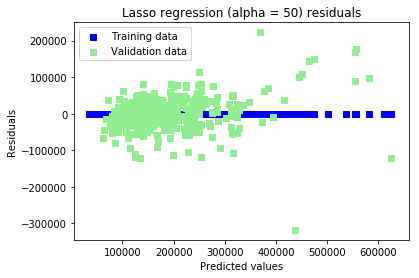

In [238]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
reg_tree = DecisionTreeRegressor()  
  
# fit the regressor with X and Y data 
reg_tree.fit(X_train, y_train) 


# predictions for training and test set.
reg_tree_train_pred = (reg_tree.predict(X_train))
reg_tree_test_pred = pos_func(reg_tree.predict(X_test))


# RMSE of log of Sale Price
reg_tree_train_rmse = rmse_log(y_train, reg_tree_train_pred)
reg_tree_test_rmse = rmse_log(y_test, reg_tree_test_pred)

# display model fit metrics.
print('Training set log rmse score: {:2f}'.format(reg_tree_train_rmse))
print('Test set log rmse score: {:2f}'.format(reg_tree_test_rmse))


# residuals
reg_tree_train_resids = reg_tree_train_pred - y_train
reg_tree_test_resids = reg_tree_test_pred - y_test


# Plot residuals
plt.scatter(reg_tree_train_pred, reg_tree_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(reg_tree_test_pred, reg_tree_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Lasso regression (alpha = 50) residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

In [239]:
# predictions
reg_tree_predicts = pos_func(reg_tree.predict(test_data.drop('Id', axis = 1)))
reg_tree_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':reg_tree_predicts})
reg_tree_submission = reg_tree_submission.set_index('Id')

display(reg_tree_submission.head())

# reg_tree_submission.to_csv('../submissions/01_simple_models/reg_tree_regression.csv')

,SalePrice
Id,
1461,100000.0
1462,132500.0
1463,201000.0
1464,174000.0
1465,201000.0


# Ensemble model

In [240]:
# weight each prediction according to the following weights.
w1 = 1/3
w2 = 1/3
w3 = 1/3
ensemble_sub = (w1 * ridge_grid_submission) + (w2 * lasso_grid_submission) + (w3 * reg_tree_submission)

display(ensemble_sub.head())
# ensemble_sub.to_csv('../submissions/01_simple_models/ensemble_sub.csv')

,SalePrice
Id,
1461,113175.819984
1462,149271.552487
1463,187967.530491
1464,189367.377744
1465,202801.726981


# Results

linear regression -  0.56569

lasso regression - 0.14915

ridge regression - 0.15793

regression tree - 0.22145

ensemble model - 0.13744
